In [47]:
from flickplay.get_connections import get_pymysql_con, get_alchemy_con
from flickplay.mongo import get_mongo_db_obj
from flickplay import query
import pandas as pd
import numpy as np

conp = get_pymysql_con()

q="""select event, $user_id, count(*) cnt
from ( select event, date, $user_id from fpa.events 
where date>='2022-12-01'  and date < '2023-1-1') x
GROUP BY event, $user_id;"""

df = pd.read_sql(q, conp)

users = pd.read_sql('''SELECT * FROM fpa.users2''', conp)

notOwn = users[(users.anonymous==0) & (users.ownsCertifiedNFT==0) & (users.isWeb3==1)]
own = users[(users.anonymous==0) & (users.ownsCertifiedNFT==1) & (users.isWeb3==1)]

df = df[df.event!='performance__network'].sort_values(by='cnt', ascending=False)

df

,event,$user_id,cnt
2530,video__seen,609d510c4244340b2a77c83a,4031
12106,video__watch,636d64c6032346d36fb32c99,3628
3295,video__seen,62c7adc4b8deb3d981f8b8bc,3101
1319,video__seen,6293081e82c92e0a0ca0fd92,3044
2531,video__watch,609d510c4244340b2a77c83a,2918
...,...,...,...
17174,profile_wallet__load_list,6395f9c230baa14e54e9be44,1
17173,login__walletconnect,6395f9c230baa14e54e9be44,1
17172,login__apple,6395f9c230baa14e54e9be44,1
17170,profile__signin_signup,6395f9c230baa14e54e9be44,1


In [48]:
notOwnEventCounts = df[df['$user_id'].isin(notOwn.user_id)]
ownEventCounts    = df[df['$user_id'].isin(own.user_id)]

sums = df[['$user_id','cnt']].groupby('$user_id').sum().sort_values(by='cnt', ascending=False)
sums

,cnt
$user_id,
6293081e82c92e0a0ca0fd92,27772
62c7adc4b8deb3d981f8b8bc,22878
609d510c4244340b2a77c83a,20195
63316470d7d49d45584ccc5e,18888
62a1e07c309538d8a0a774ce,18041
...,...
606178c640cf54f5075751c3,1
61e6bdc0b749dcd808b9041f,1
62c73d6c4e94c3c2d1b65f26,1


In [49]:
sumsE = df[['event','cnt']].groupby('event').sum().sort_values(by='cnt', ascending=False)
sumsE.iloc[:10]

,cnt
event,
video__seen,54854
feature_session__start,39218
video__watch,34007
feature_session__end,32558
video__swipe,26559
profile_video__load_list,18093
nav_bar__tab,16901
map__coin_seen,16726
session__start,12344


In [50]:
def get_count(user_id):
    try:
        return sums.loc[user_id].cnt
    except:
        return 0
    
df['sum_cnt'] = df['$user_id'].apply(lambda x: get_count(x))
df['event_frac'] = df.cnt/df.sum_cnt
df['event_pct'] = df.cnt/df.sum_cnt*100

notOwnE = df[df['$user_id'].isin(notOwn.user_id)]
ownE    = df[df['$user_id'].isin(own.user_id)]

ownE[ownE.event=='video__swipe'].mean()

cnt            236.685714
sum_cnt       4365.985714
event_frac       0.076945
event_pct        7.694481
dtype: float64

In [51]:
events = [
    'video__swipe',
    'video__seen',
    'homefeed__load_page',
    'video__comment_post',
    'video_finalize__post']

for event in events:
    print()
    print('owns NFT', event)
    print(ownE[ownE.event==event].mean(),'\n')
    print('not owns NFT', event)
    print(notOwnE[notOwnE.event==event].mean())
    print()


owns NFT video__swipe
cnt            236.685714
sum_cnt       4365.985714
event_frac       0.076945
event_pct        7.694481
dtype: float64 

not owns NFT video__swipe
cnt            111.511111
sum_cnt       1466.333333
event_frac       0.101592
event_pct       10.159202
dtype: float64


owns NFT video__seen
cnt            402.322581
sum_cnt       3341.021505
event_frac       0.102201
event_pct       10.220123
dtype: float64 

not owns NFT video__seen
cnt            113.602941
sum_cnt       1044.220588
event_frac       0.114831
event_pct       11.483071
dtype: float64


owns NFT homefeed__load_page
cnt             62.602041
sum_cnt       3173.224490
event_frac       0.028790
event_pct        2.878954
dtype: float64 

not owns NFT homefeed__load_page
cnt            21.858824
sum_cnt       843.882353
event_frac      0.037597
event_pct       3.759717
dtype: float64


owns NFT video__comment_post
cnt             27.323529
sum_cnt       7754.617647
event_frac       0.005690
event_pct     

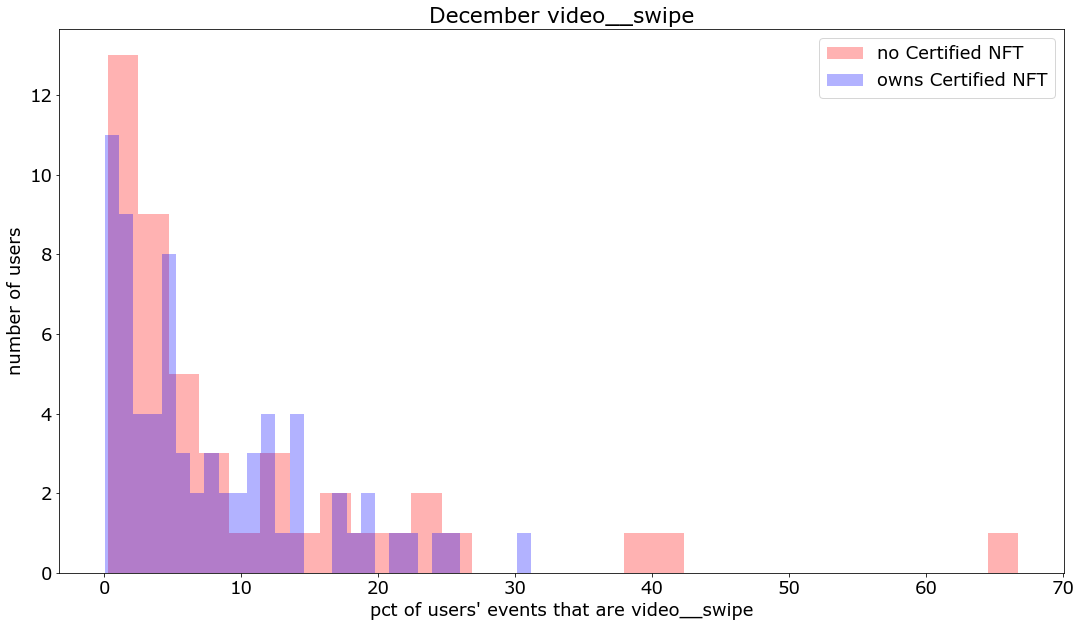

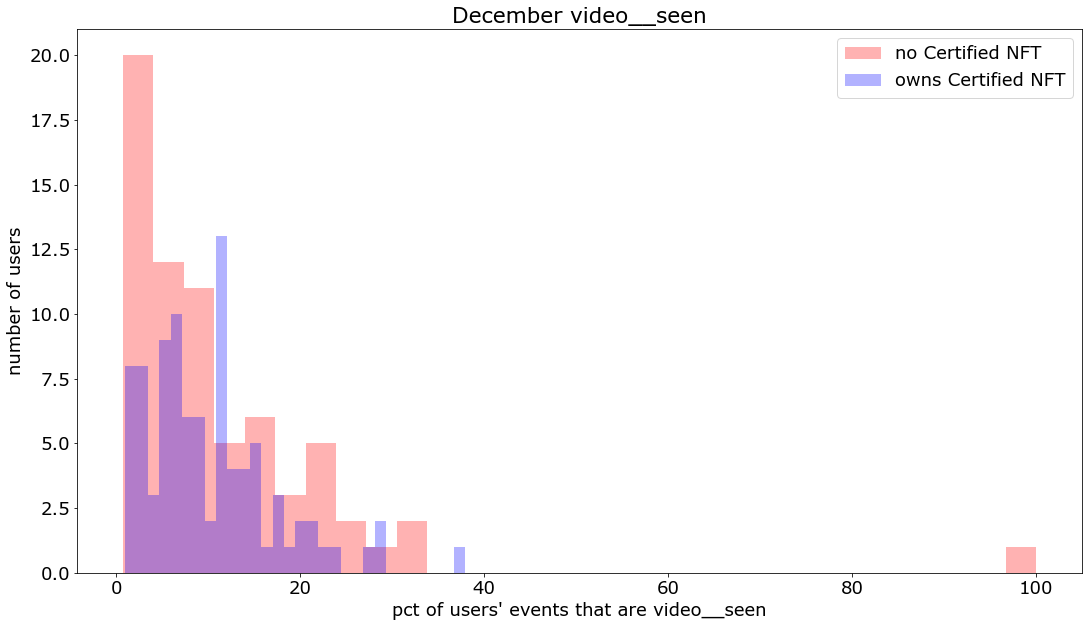

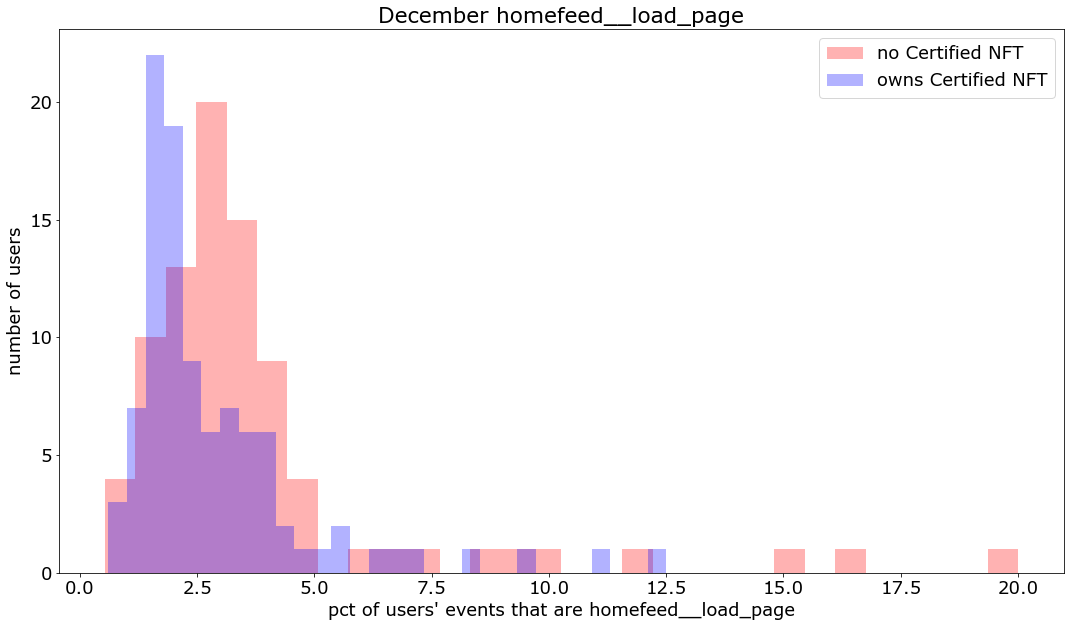

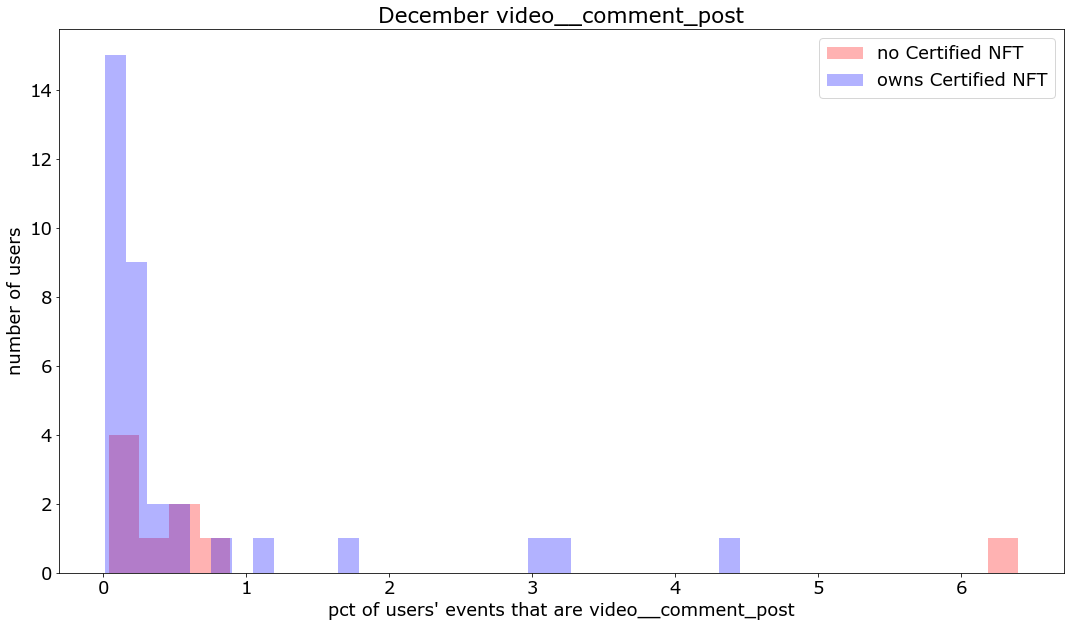

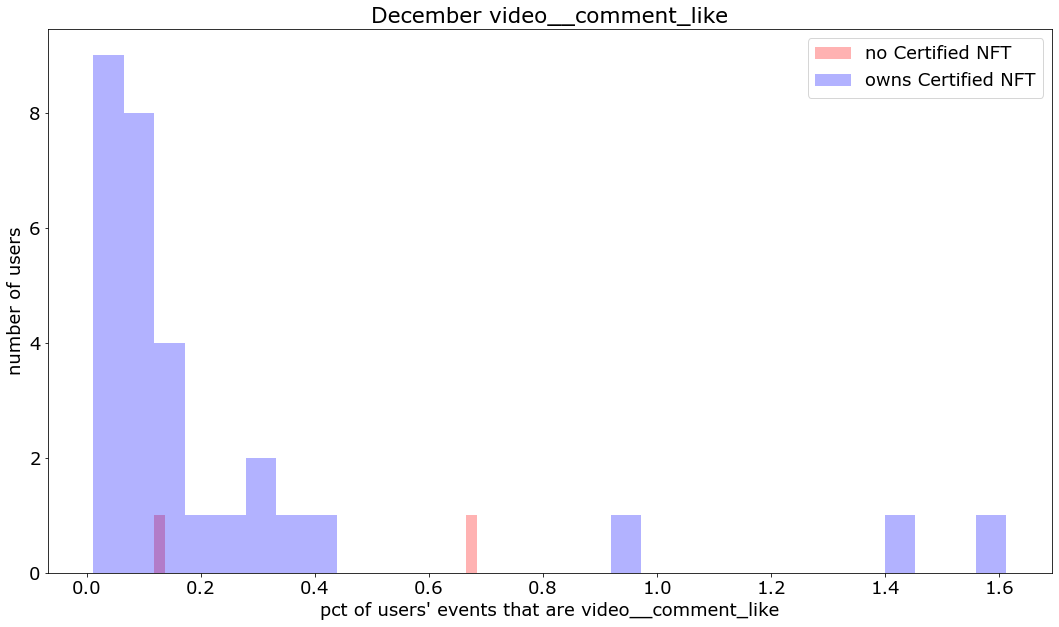

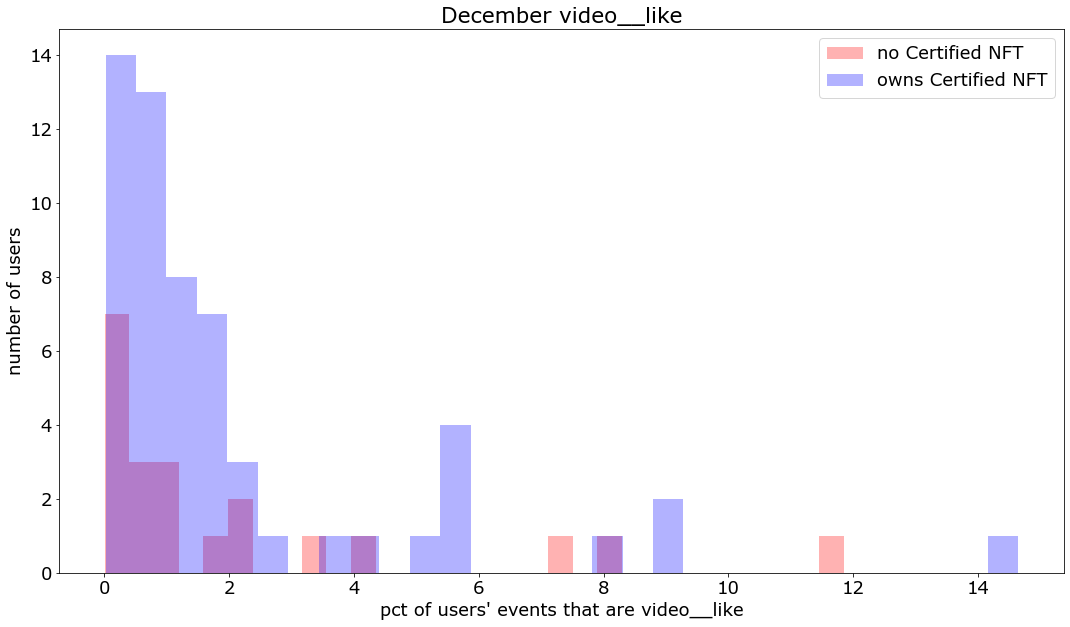

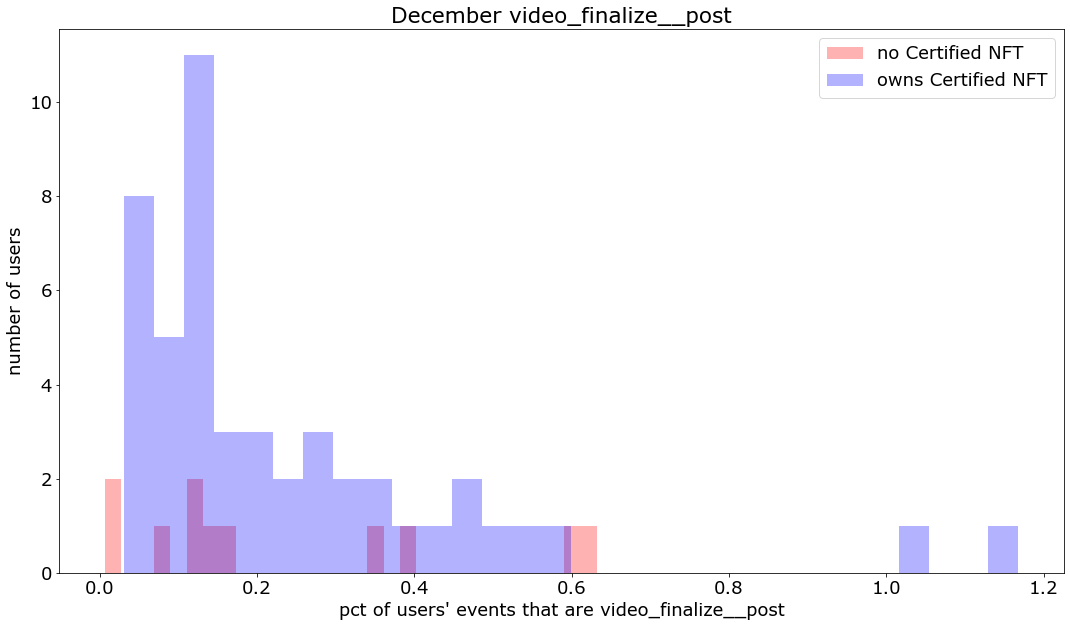

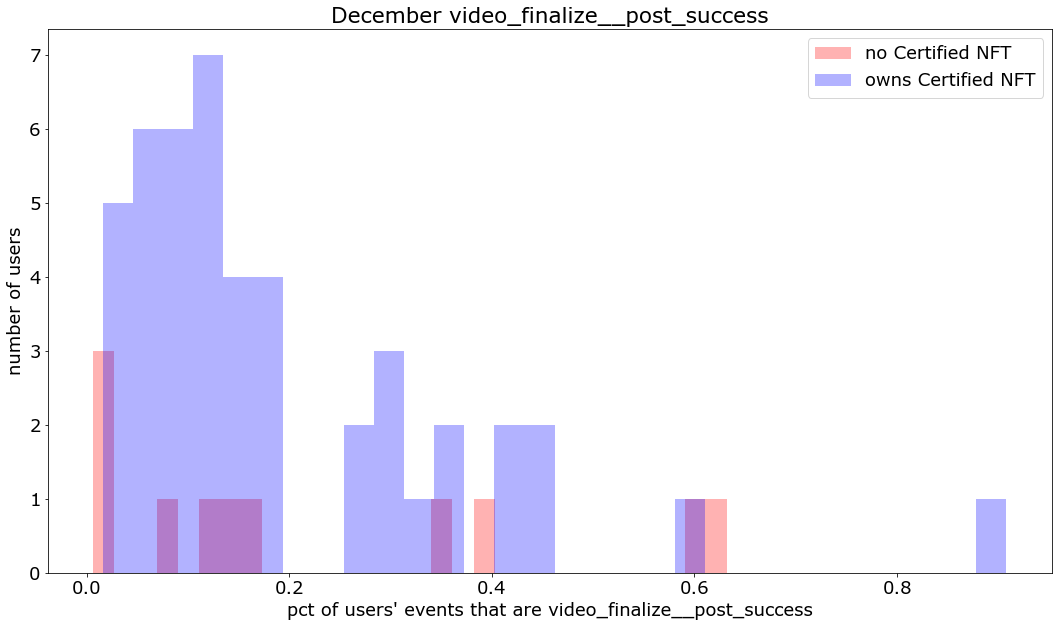

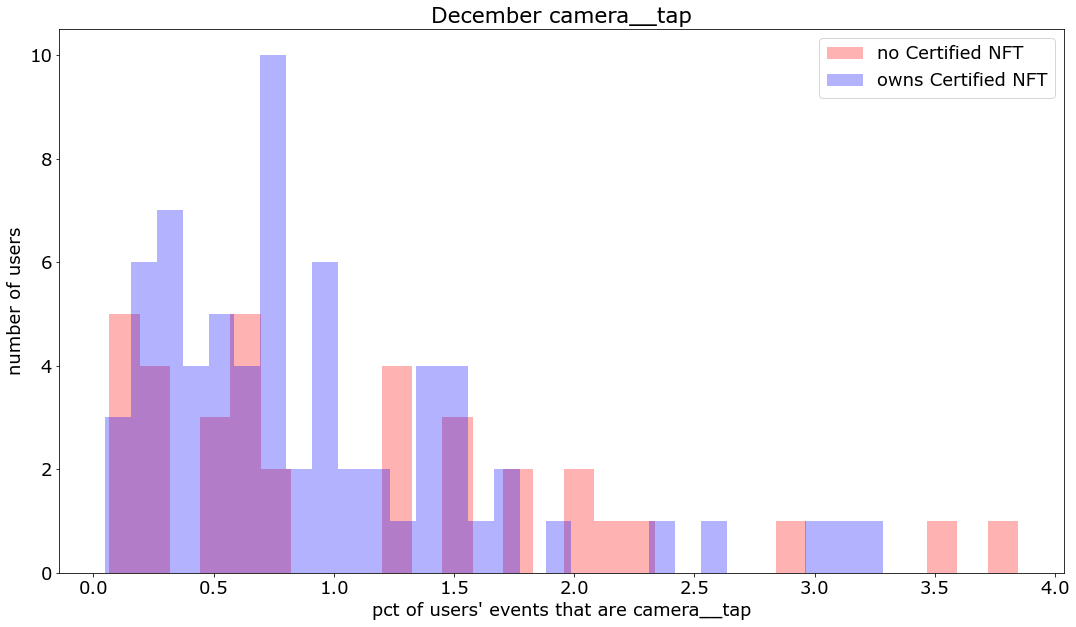

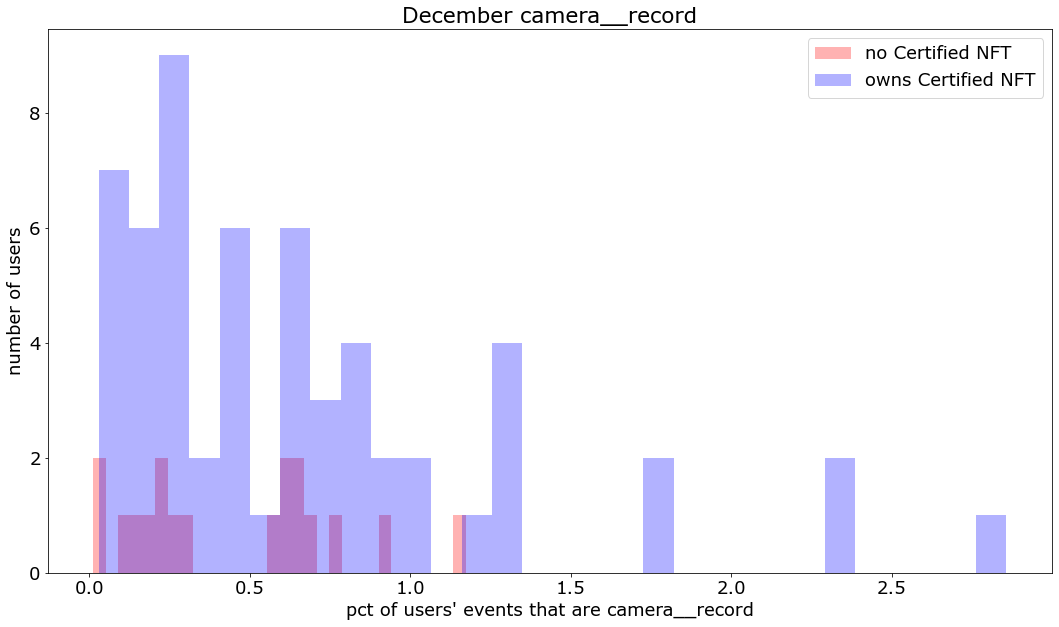

In [52]:
import matplotlib.pyplot as plt
from flickplay.utils import make_big



events = [
    'video__swipe',
    'video__seen',
    'homefeed__load_page',
    'video__comment_post',
    'video__comment_like',
    'video__like',
    'video_finalize__post',
    'video_finalize__post_success',
    # camera - make a recording, play with AR, share video, draft video etc
    'camera__tap',
    'camera__record']

DENSITY=False

for event in events:
    
    fig, ax = make_big()
    # plt.hist(notOwnE[notOwnE.event==event].event_pct, label='no NFT', bins=30)
    plt.hist(notOwnE[notOwnE.event==event].event_pct, label='no Certified NFT', bins=30, density=DENSITY, fc=(1,0,0,0.3))

    plt.hist(ownE[ownE.event==event].event_pct, label='owns Certified NFT', bins=30, density=DENSITY,fc=(0,0,1,0.3))
   

    plt.xlabel(f'pct of users\' events that are {event}')
    if DENSITY:
        plt.ylabel('pct of users')
    else:
        plt.ylabel('number of users')
    plt.legend()
    # plt.yscale('log')
    plt.title('December '+event)
    plt.savefig(f'/Users/allen/Desktop/event_hist2/dec-{event}.jpg')
    plt.show()

In [34]:
# len(set(notOwnE['$user_id']))

141